In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path='/content/gdrive/My Drive/Colab Notebooks/studies/machine learning for graphs and sequential data/project_2'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd '/content/gdrive/My Drive/Colab Notebooks/studies/machine learning for graphs and sequential data/project_2'

/content/gdrive/My Drive/Colab Notebooks/studies/machine learning for graphs and sequential data/project_2


In [5]:
%load_ext autoreload
%autoreload 2
import torch
from torch.optim import Adam
from matplotlib import pyplot as plt
from utils import get_mnist_data
from models import ConvNN, SmoothClassifier
from training_and_evaluation import train_model
from torch.nn.functional import cross_entropy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Project 2, part 3: Randomized smoothing training (60 pt)
In this notebook we train a smooth classifier via the principle of randomized smoothing.

## Your task
Complete the missing code in the respective files, i.e. `models.py`, and this notebook. Make sure that all the functions follow the provided specification, i.e. the output of the function exactly matches the description in the docstring. 

Specifically, for this part you will have to implement the following functions / classes:  
**`models.py`**:
* `SmoothClassifier`:
 * `certify` (20pt)
 * `predict` (20pt)
 * `_sample_noise_predictions` (20pt)

## General remarks
Do not add or modify any code outside of the following comment blocks, or where otherwise explicitly stated.

``` python
##########################################################
# YOUR CODE HERE
...
##########################################################
```
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.

The following things are **NOT** allowed:
- Using additional `import` statements
- Copying / reusing code from other sources (e.g. code by other students)

If you plagiarise even for a single project task, you won't be eligible for the bonus this semester.

In [0]:
mnist_trainset = get_mnist_data(train=True)
mnist_testset = get_mnist_data(train=False)
use_cuda = torch.cuda.is_available()
base_classifier = ConvNN()
if use_cuda:
    base_classifier = base_classifier.cuda()

In [0]:
sigma = 1
batch_size = 128
lr = 1e-3
epochs = 1

### Creating a smooth classifier
Implement the `SmoothClassifier` class in `models.py` and follow the docstrings there.

In [0]:
model = SmoothClassifier(base_classifier=base_classifier, num_classes=10, sigma=sigma)
opt = Adam(model.parameters(), lr=lr)

In [0]:
def loss_function(x, y, model):
    logits = model(x).cpu()
    loss = cross_entropy(logits, y)
    return loss, logits

In [12]:
losses, accuracies = train_model(model, mnist_trainset, batch_size=batch_size, loss_function=loss_function, optimizer=opt)

In [0]:
torch.save(model.base_classifier.state_dict(), "models/randomized_smoothing.checkpoint")

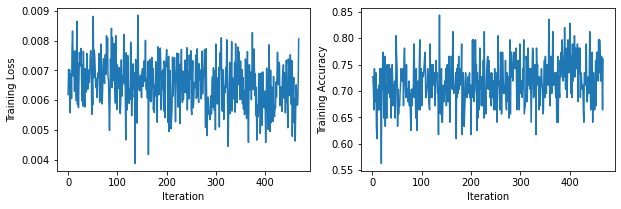

In [14]:
fig = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.subplot(122)
plt.plot(accuracies)
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy")
plt.show()

In [0]:
losses[-1], accuracies[-1]

(tensor(0.0083, grad_fn=<DivBackward0>), 0.7708333333333334)

In [0]:
from torch.utils.data import Dataset, DataLoader
#test_loader = DataLoader(mnist_testset, batch_size=1, shuffle=False)
test_loader = DataLoader(mnist_testset, batch_size=1000, shuffle=False)

In [0]:
test_loader, len(mnist_testset)

(<torch.utils.data.dataloader.DataLoader at 0x7fa635d81710>, 10000)

In [0]:
from tqdm.autonotebook import tqdm
for x, y in tqdm(iter(test_loader), total=len(mnist_testset)):
    x = x.to(model.device())
    class_counts=model._sample_noise_predictions(x,10,1)
    top_class, radius=model.certify(x,10, 100, 0.05, 1)
    prediction=model.predict(x, 10, .3,1)
    print(class_counts)
    print(top_class, radius)
    print(prediction)

tensor([ 847, 1360,  976, 1114, 1095,  820, 1046, 1164,  837,  741],
       device='cuda:0')
1 nan
tensor(1)
tensor([ 880, 1316,  921, 1115, 1151,  860, 1035, 1204,  822,  696],
       device='cuda:0')
1 nan
tensor(1)
tensor([ 948, 1206,  875, 1190, 1136,  880, 1061, 1175,  866,  663],
       device='cuda:0')
7 nan
-1
tensor([ 963, 1308,  950, 1068, 1160,  806, 1095, 1132,  866,  652],
       device='cuda:0')
1 nan
tensor(1)
tensor([ 912, 1402,  922, 1062, 1111,  742,  964, 1217,  858,  810],
       device='cuda:0')
1 nan
tensor(1)
tensor([1064, 1159,  888, 1041, 1067,  779, 1254, 1142,  835,  771],
       device='cuda:0')
6 nan
-1
tensor([1049, 1084,  923, 1065, 1207,  805, 1183, 1193,  946,  545],
       device='cuda:0')
7 nan
tensor(7)
tensor([1000, 1081,  945,  986, 1020,  650, 1243, 1289, 1151,  635],
       device='cuda:0')
7 nan
tensor(7)
tensor([1118, 1070,  843, 1027, 1080,  777, 1190, 1215,  924,  756],
       device='cuda:0')
6 nan
-1
tensor([1090, 1267,  856,  969, 1026,  7

In [0]:
num_samples=1000
n0=100
batch_size=1000
alpha=0.05
class_counts=model._sample_noise_predictions(x, n0, 1)
class_counts_for_certificate = model._sample_noise_predictions(x,num_samples, batch_size)
        
top_class = class_counts.argmax().item()
top_class_count = class_counts_for_certificate[top_class].item()
        
p_A_lower_bound = lower_confidence_bound(top_class_count, num_samples, alpha)

# class_counts=model._sample_noise_predictions(x, 100, 1)
# class_counts_for_certificate = self._sample_noise_predictions(inputs,num_samples, batch_size)
        
# top_class = class_counts.argmax().item()
# top_class_count = class_counts_for_certificate[top_class].item()
        
# p_A_lower_bound = lower_confidence_bound(top_class_count, num_samples, alpha)

RuntimeError: ignored

In [0]:
class_counts=model._sample_noise_predictions(x, 100, 1)

In [0]:
class_counts

tensor([10565, 12603,  8181,  9586, 10901,  7506, 11477, 13159, 10612,  5410],
       device='cuda:0')

In [0]:
class_counts_for_certificate = model._sample_noise_predictions(x,1000, 1)
class_counts_for_certificate

tensor([105396, 126666,  82377,  94362, 109529,  75922, 115388, 132025, 105129,
         53206], device='cuda:0')

In [0]:
top_class = class_counts.argmax().item()
top_class

7

In [0]:
top_class_count = class_counts_for_certificate[top_class].item()
top_class_count

132025

In [0]:
from models import lower_confidence_bound
p_A_lower_bound = lower_confidence_bound(top_class_count, 1000, 0.05)
p_A_lower_bound

nan